# 💻 Optimización por Enjambre de Partículas (PSO)

En este notebbook veremos la teoría y la implementación paso a paso del algoritmo de **Optimización por Enjambre de Partículas (PSO)**. Utilizaremos la función de costo **Peaks** como ejemplo de problema de optimización y visualizaremos la evolución de la búsqueda.

-----

### 1. Introducción al algoritmo PSO

El algoritmo de Optimización por Enjambre de Partículas (PSO) es una técnica de **optimización estocástica** inspirada en el comportamiento social de bandadas de pájaros o bancos de peces. Fue desarrollado por James Kennedy y Russell Eberhart en 1995.

El PSO se utiliza para encontrar el **mejor punto (óptimo)** en un espacio de búsqueda complejo, en donde la función objetivo es no derivable. La idea central es que un conjunto de soluciones candidatas, llamadas **partículas**, se mueven a través del espacio de búsqueda, influenciadas por su propia mejor posición histórica y la mejor posición encontrada por todo el enjambre.

#### Conceptos Clave:

  * **Partícula:** Una solución candidata en el espacio de búsqueda. Posee una **posición** ($x_i$) y una **velocidad** ($v_i$).
  * **Posición Personal Óptima (**$pbest_i$**):** La mejor posición que ha encontrado la partícula $i$ a lo largo del tiempo.
  * **Posición Global Óptima (**$gbest$**):** La mejor posición que ha encontrado **todo el enjambre** a lo largo del tiempo.

-----

### 2. Ecuaciones de actualización del PSO

El movimiento de cada partícula se rige por dos ecuaciones principales: la **actualización de la velocidad** y la **actualización de la posición**.

#### A. Actualización de la velocidad

La nueva velocidad de la partícula $i$ se calcula como una combinación de tres componentes:

$$
v_{i}^{t+1} = \omega v_{i}^{t} + c_1 r_1 (pbest_i - x_i^{t}) + c_2 r_2 (gbest - x_i^{t})
$$

Donde:

  * $v_{i}^{t+1}$: Nueva velocidad de la partícula $i$.
  * $\omega$ (**Inercia**): Coeficiente que controla el peso de la velocidad anterior. Ayuda a la exploración (mantener la dirección).
  * $c_1$ (**Atracción Cognitiva**): Coeficiente que pondera la influencia de la mejor posición personal ($pbest$).
  * $c_2$ (**Atracción Social**): Coeficiente que pondera la influencia de la mejor posición global ($gbest$).
  * $r_1, r_2$: Vectores de números aleatorios uniformes en el rango $[0, 1]$.
  * $(pbest_i - x_i^{t})$: **Componente Cognitivo** (Memoria de la partícula). Mueve la partícula hacia su mejor posición histórica.
  * $(gbest - x_i^{t})$: **Componente Social** (Conocimiento del enjambre). Mueve la partícula hacia la mejor posición global encontrada.

#### B. Actualización de la posición

La nueva posición de la partícula $i$ se calcula simplemente sumando la nueva velocidad a la posición actual:

$$
x_{i}^{t+1} = x_i^{t} + v_{i}^{t+1}
$$

-----

### 3. Implementación del PSO

Comenzaremos importando las librerías necesarias.

In [1]:
# Importar librerías
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import rosen # Usaremos Peaks, pero scipy tiene otras para referencia
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation, PillowWriter
import matplotlib.patches as mpatches

#### Paso 3.1: Definir la función de costo (función objetivo)

Usaremos la función **Peaks**, que es una función de prueba clásica en MATLAB y tiene múltiples máximos y mínimos. **Como estamos buscando el mínimo (minimización)**, usaremos la negativa de la función Peaks estándar.

In [2]:
def peaks_function(X):
    """
    Función de prueba Peaks: f(x, y) = 3(1-x)^2 * exp(-x^2 - (y+1)^2) -
                                         10(x/5 - x^3 - y^5) * exp(-x^2 - y^2) -
                                         1/3 * exp(-(x+1)^2 - y^2)

    Usaremos la negativa para encontrar el mínimo global (minimización).
    """
    x, y = X[:, 0], X[:, 1]

    Z = 3 * (1 - x)**2 * np.exp(-(x**2) - (y + 1)**2) - \
        10 * (x/5 - x**3 - y**5) * np.exp(-x**2 - y**2) - \
        1/3 * np.exp(-(x + 1)**2 - y**2)

    # Devolvemos el valor negativo para convertir el problema en una minimización
    return -Z

# Definir límites del espacio de búsqueda para Peaks
BOUNDS = np.array([[-3.0, 3.0],  # Límite para x
                   [-3.0, 3.0]]) # Límite para y
DIMENSION = 2 # Es un problema 2D

#### Paso 3.2: Definir los parámetros del PSO

Estos valores suelen ajustarse experimentalmente.

In [3]:
# Parámetros del PSO
N_PARTICLES = 10           # Número de partículas (tamaño del enjambre)
MAX_ITER = 50              # Número máximo de iteraciones
W = 0.729                  # Coeficiente de Inercia
C1 = 1.4944                # Coeficiente de Atracción Cognitiva
C2 = 1.4944                # Coeficiente de Atracción Social
V_MAX = 0.5                # Límite de velocidad (para evitar explosión)

#### Paso 3.3: Inicialización del enjambre de partículas

Las posiciones y velocidades iniciales se generan aleatoriamente dentro de los límites.

In [4]:
# Inicialización
# 1. Posiciones
X = np.random.uniform(low=BOUNDS[:, 0], high=BOUNDS[:, 1], size=(N_PARTICLES, DIMENSION))

# 2. Velocidades (inicializadas cerca de cero)
V = np.random.uniform(low=-V_MAX, high=V_MAX, size=(N_PARTICLES, DIMENSION))

# 3. pbest (Mejor Posición Personal)
PBest_Pos = X.copy()
PBest_Cost = peaks_function(PBest_Pos)

# 4. gbest (Mejor Posición Global)
gbest_index = np.argmin(PBest_Cost)
gbest_pos = PBest_Pos[gbest_index].copy()
gbest_cost = PBest_Cost[gbest_index]

# Lista para almacenar el historial de posiciones para la visualización
history = [X.copy()]

#### Paso 3.4: Proceso iterativo del PSO

Aplicamos las ecuaciones de actualización iterativamente.

In [5]:
# Cilco de Optimización
for t in range(MAX_ITER):

    # --- 1. Calcular nueva Velocidad ---
    # Componentes aleatorios
    r1 = np.random.uniform(0.0, 1.0, size=(N_PARTICLES, DIMENSION))
    r2 = np.random.uniform(0.0, 1.0, size=(N_PARTICLES, DIMENSION))

    # Componente Cognitivo (atraccíon a pbest)
    cognitive_component = C1 * r1 * (PBest_Pos - X)

    # Componente Social (atracción a gbest)
    social_component = C2 * r2 * (gbest_pos - X)

    # Ecuación completa de la velocidad: Inercia + Cognitivo + Social
    V = W * V + cognitive_component + social_component

    # Limitar la velocidad para control
    V = np.clip(V, -V_MAX, V_MAX)

    # --- 2. Calcular nueva Posición ---
    X = X + V

    # Asegurar que las partículas permanezcan dentro de los límites
    for dim in range(DIMENSION):
        X[:, dim] = np.clip(X[:, dim], BOUNDS[dim, 0], BOUNDS[dim, 1])

    # --- 3. Evaluar y Actualizar pbest y gbest ---
    current_cost = peaks_function(X)

    # Actualizar pbest
    better_pbest = current_cost < PBest_Cost
    PBest_Cost[better_pbest] = current_cost[better_pbest]
    PBest_Pos[better_pbest] = X[better_pbest]

    # Actualizar gbest
    min_current_cost = np.min(current_cost)
    if min_current_cost < gbest_cost:
        gbest_cost = min_current_cost
        gbest_index_current = np.argmin(current_cost)
        gbest_pos = X[gbest_index_current].copy()

    # Guardar el estado actual para visualización
    history.append(X.copy())

    # Mostrar progreso
    print(f"Iteración {t+1}/{MAX_ITER}: Costo Mínimo (gbest) = {gbest_cost:.4f}")

print("\n--- Resultados Finales ---")
# Recuerda que minimizamos Peaks, así que el máximo de Peaks es el negativo del costo.
print(f"Mejor Posición (x, y): {gbest_pos}")
print(f"Valor Mínimo (-Peaks): {gbest_cost:.4f}")
print(f"Valor Máximo (Peaks): {-gbest_cost:.4f}")

Iteración 1/50: Costo Mínimo (gbest) = -1.7684
Iteración 2/50: Costo Mínimo (gbest) = -3.4737
Iteración 3/50: Costo Mínimo (gbest) = -3.7588
Iteración 4/50: Costo Mínimo (gbest) = -3.7588
Iteración 5/50: Costo Mínimo (gbest) = -3.7588
Iteración 6/50: Costo Mínimo (gbest) = -3.7588
Iteración 7/50: Costo Mínimo (gbest) = -3.7588
Iteración 8/50: Costo Mínimo (gbest) = -3.7588
Iteración 9/50: Costo Mínimo (gbest) = -3.7588
Iteración 10/50: Costo Mínimo (gbest) = -3.7588
Iteración 11/50: Costo Mínimo (gbest) = -3.7588
Iteración 12/50: Costo Mínimo (gbest) = -3.7588
Iteración 13/50: Costo Mínimo (gbest) = -3.7588
Iteración 14/50: Costo Mínimo (gbest) = -3.7588
Iteración 15/50: Costo Mínimo (gbest) = -3.7588
Iteración 16/50: Costo Mínimo (gbest) = -3.7588
Iteración 17/50: Costo Mínimo (gbest) = -3.7588
Iteración 18/50: Costo Mínimo (gbest) = -3.7672
Iteración 19/50: Costo Mínimo (gbest) = -3.7672
Iteración 20/50: Costo Mínimo (gbest) = -3.7672
Iteración 21/50: Costo Mínimo (gbest) = -3.7752
I

-----

### 4. Visualización de la evolución del enjambre de partículas

Visualizar el movimiento de las partículas sobre la superficie de búsqueda de la función de costo es crucial para entender cómo funciona el PSO.

#### 4.1. Preparar la superficie de búsqueda de la Función Peaks mediante la construcción de un meshgrid

In [6]:
# Preparar la cuadrícula para la gráfica 3D y de contorno
x_grid = np.linspace(BOUNDS[0, 0], BOUNDS[0, 1], 100)
y_grid = np.linspace(BOUNDS[1, 0], BOUNDS[1, 1], 100)
X_mesh, Y_mesh = np.meshgrid(x_grid, y_grid)

# Reformar para la función de costo (requiere una matriz Nx2)
Grid_input = np.vstack([X_mesh.ravel(), Y_mesh.ravel()]).T

# Calcular los valores de la función (negativa)
Z_mesh_neg = peaks_function(Grid_input).reshape(X_mesh.shape)
Z_mesh_pos = -Z_mesh_neg # La función Peaks original (positiva)

#### 4.2. Gráfica 3D de la función Peaks y las partículas

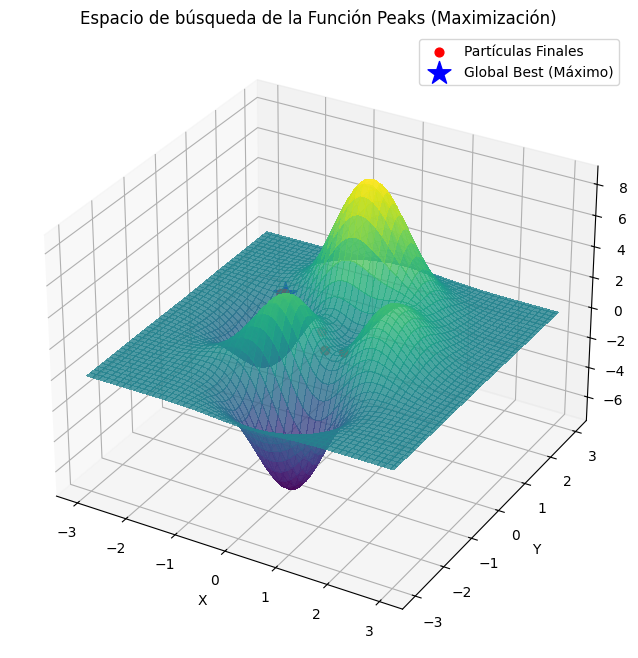

In [7]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Superficie de la función Peaks (positiva, para ver los picos)
surf = ax.plot_surface(X_mesh, Y_mesh, Z_mesh_pos, cmap='viridis', alpha=0.8,
                       linewidth=0, antialiased=False)

# Añadir las posiciones finales de las partículas
final_positions = history[-1]
final_costs_pos = -peaks_function(final_positions) # El valor real de Peaks
ax.scatter(final_positions[:, 0], final_positions[:, 1], final_costs_pos,
           color='red', marker='o', s=40, label='Partículas Finales')
ax.scatter(gbest_pos[0], gbest_pos[1], -gbest_cost,
           color='blue', marker='*', s=300, label='Global Best (Máximo)')

ax.set_title('Espacio de búsqueda de la Función Peaks (Maximización)')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('f(x, y)')
plt.legend()
plt.show()

#### 4.3. Visualización de la Evolución (Gráfica de Contorno)

Esta gráfica de contorno te permite ver la **trayectoria** del enjambre sobre el espacio 2D.

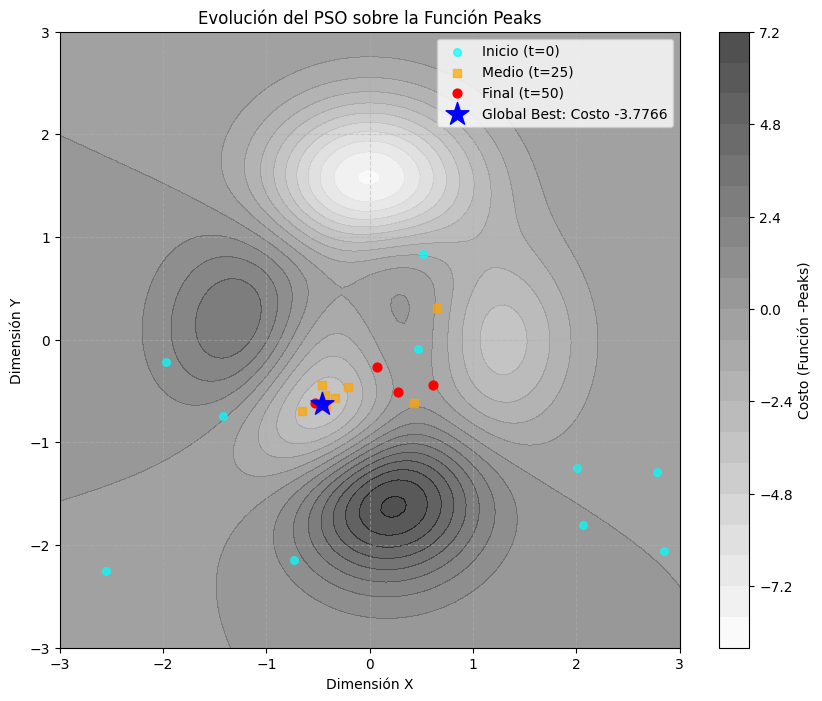

In [8]:
# Gráfica de Contorno y Evolución del Enjambre
fig, ax = plt.subplots(figsize=(10, 8))

# 1. Trazar los contornos de la función (mostramos -Z, la que minimizamos)
contour = ax.contourf(X_mesh, Y_mesh, Z_mesh_neg, levels=20, cmap='gray_r', alpha=0.7)
fig.colorbar(contour, label='Costo (Función -Peaks)')

# 2. Trazar la posición de las partículas en diferentes momentos
# Elegiremos el inicio (t=0), un punto medio (t=25), y el final (t=50)

# Posición Inicial (t=0)
ax.scatter(history[0][:, 0], history[0][:, 1], color='cyan', marker='o', s=30,
           label='Inicio (t=0)', alpha=0.7)

# Posición Media (t=MAX_ITER/2)
if MAX_ITER >= 2:
    mid_index = MAX_ITER // 2
    ax.scatter(history[mid_index][:, 0], history[mid_index][:, 1], color='orange',
               marker='s', s=30, label=f'Medio (t={mid_index})', alpha=0.7)

# Posición Final (t=MAX_ITER)
ax.scatter(history[-1][:, 0], history[-1][:, 1], color='red', marker='o', s=40,
           label=f'Final (t={MAX_ITER})')

# 3. Marcar el Global Best (Mínimo)
ax.scatter(gbest_pos[0], gbest_pos[1], color='blue', marker='*', s=300,
           label=f'Global Best: Costo {gbest_cost:.4f}')

ax.set_title('Evolución del PSO sobre la Función Peaks')
ax.set_xlabel('Dimensión X')
ax.set_ylabel('Dimensión Y')
ax.set_xlim(BOUNDS[0])
ax.set_ylim(BOUNDS[1])
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

#### 4.4. Animación de la evolución de las partículas
Para ver realmente cómo el enjambre explora el espacio de búsqueda y converge hacia el óptimo, crearemos una animación utilizando el historial de posiciones (history) que se guardó en el ciclo principal.


 Animación guardada como 'pso_evolution.gif'


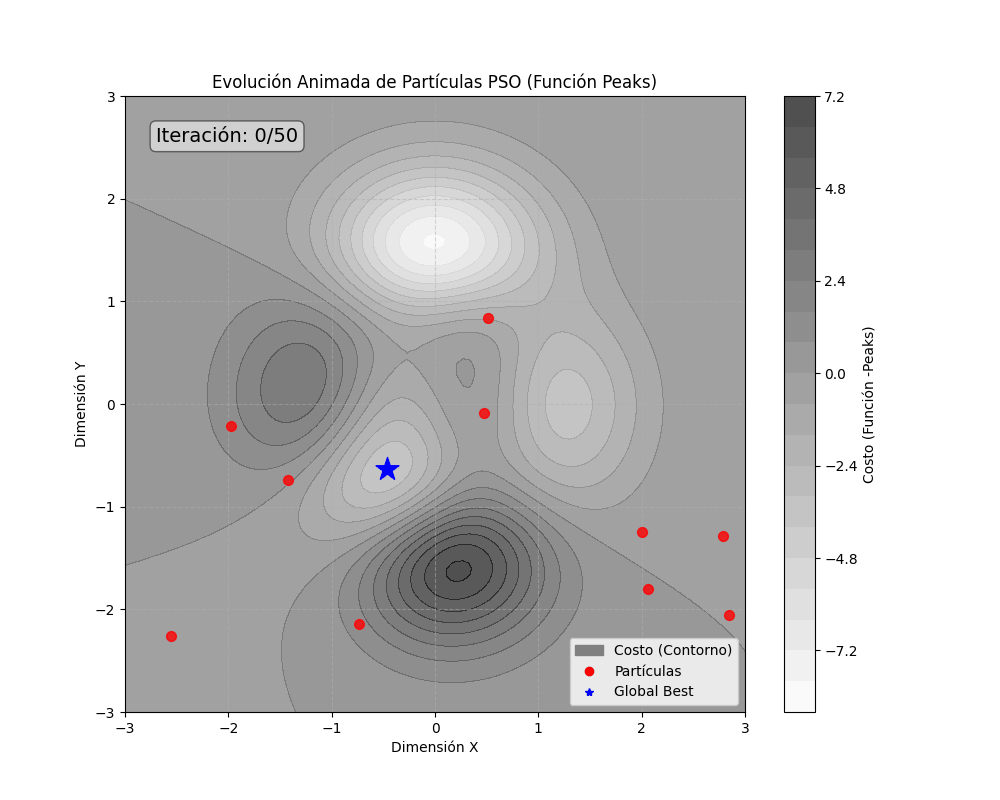

In [9]:
# --- 1. Configuración de la Figura Base ---
fig, ax = plt.subplots(figsize=(10, 8))

# Trazar los contornos de la función (-Peaks, la que minimizamos)
contour = ax.contourf(X_mesh, Y_mesh, Z_mesh_neg, levels=20, cmap='gray_r', alpha=0.7)
fig.colorbar(contour, label='Costo (Función -Peaks)')

# Configurar límites y título
ax.set_title('Evolución Animada de Partículas PSO (Función Peaks)')
ax.set_xlabel('Dimensión X')
ax.set_ylabel('Dimensión Y')
ax.set_xlim(BOUNDS[0])
ax.set_ylim(BOUNDS[1])
ax.grid(True, linestyle='--', alpha=0.5)

# Marcar el Global Best (posición final encontrada)
ax.scatter(gbest_pos[0], gbest_pos[1], color='blue', marker='*', s=300,
           label=f'Global Best: {gbest_pos[0]:.2f}, {gbest_pos[1]:.2f}', zorder=3)

# --- 2. Elementos a Animar ---
# Scatter plot para las posiciones de las partículas
scat = ax.scatter([], [], color='red', marker='o', s=50, alpha=0.8, zorder=2)

# Texto para mostrar la iteración actual
iter_text = ax.text(0.05, 0.95, '', transform=ax.transAxes, fontsize=14,
                    verticalalignment='top', bbox=dict(boxstyle="round", facecolor='white', alpha=0.5))

# Leyenda manual para evitar problemas con la animación
legend_elements = [mpatches.Patch(color='grey', label='Costo (Contorno)'),
                   plt.Line2D([0], [0], marker='o', color='r', label='Partículas', linestyle=''),
                   plt.Line2D([0], [0], marker='*', color='b', label='Global Best', linestyle='')]
ax.legend(handles=legend_elements, loc='lower right')


# --- 3. Función de Inicialización ---
def init():
    """Inicializa la animación (vacía los puntos)"""
    scat.set_offsets(np.empty((0, 2)))
    iter_text.set_text('')
    return scat, iter_text

# --- 4. Función de Actualización (por frame/iteración) ---
def update(frame):
    """Actualiza la posición de las partículas para el frame dado (historial[frame])"""

    # Obtener las posiciones de las partículas en la iteración 'frame'
    positions = history[frame]

    # Actualizar los puntos del scatter plot
    scat.set_offsets(positions)

    # Actualizar el texto de la iteración
    iter_text.set_text(f'Iteración: {frame}/{MAX_ITER}')

    return scat, iter_text

# --- 5. Crear y Guardar la Animación ---
# Crear la animación: Llamará a update(frame) para cada frame en el rango 0 a MAX_ITER
# Nota: history tiene MAX_ITER + 1 entradas (t=0 hasta t=MAX_ITER)
anim = FuncAnimation(fig, update, frames=len(history), init_func=init,
                     blit=True, interval=200, repeat=False)

# Guardar la animación como GIF (requiere el motor Pillow)
# El proceso de guardar puede tardar unos segundos.
try:
    writer = PillowWriter(fps=5) # 5 frames por segundo
    anim.save("pso_evolution.gif", writer=writer)
    print("\n Animación guardada como 'pso_evolution.gif'")

    # Para visualizar en un entorno de notebook (como Jupyter o Colab)
    from IPython.display import Image
    display(Image(filename='pso_evolution.gif'))

except Exception as e:
    print(f"\n Error al guardar la animación (asegúrate de tener 'Pillow' instalado): {e}")

# Cerrar la figura para evitar que se muestre como estática
plt.close(fig)

-----

### 5. Resumen

* El algoritmo de **Optimización por Enjambre de Partículas (PSO)** utiliza el conocimiento colectivo y la memoria individual para buscar soluciones óptimas.

* **Partícula ($\mathbf{x}_i$) y Velocidad ($\mathbf{v}_i$):** Cada solución es una partícula con una posición en el espacio de búsqueda y una velocidad que determina su movimiento.
* **Memoria Doble:** El movimiento está guiado por dos valores históricos:
    * **$\mathbf{pbest}_i$ (Personal Best):** La mejor posición individual encontrada.
    * **$\mathbf{gbest}$ (Global Best):** La mejor posición encontrada por todo el enjambre.
* **Fuerzas de Movimiento (Balance E-E):** La actualización de la velocidad combina tres fuerzas para equilibrar la **Exploración** (búsqueda amplia) y la **Explotación** (refinamiento local):
    1.  **Inercia ($\omega$):** Ayuda a la **exploración** y mantiene el impulso.
    2.  **Atracción Cognitiva ($c_1$):** Atrae hacia el $\mathbf{pbest}$ (memoria individual).
    3.  **Atracción Social ($c_2$):** Atrae hacia el $\mathbf{gbest}$ (conocimiento colectivo).
* **Objetivo de Optimización:** Para maximizar una función (como Peaks), se utiliza el PSO para **minimizar su función negativa** ($\text{Costo} = -\text{Función Objetivo}$).
* **Control del Algoritmo:** Los coeficientes $\omega$, $c_1$ y $c_2$ son los **parámetros de control** que definen la estrategia de búsqueda. Su ajuste es crucial para lograr una convergencia eficiente sin caer en mínimos locales.
